<a href="https://colab.research.google.com/github/zpgeng/Machine-Perception/blob/master/3_tensorflow_linear_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Linear Regression in TensorFlow


In this tutorial, you will be given the basic tools needed to make use of Tensorflow during the **[Machine Perception](https://ait.ethz.ch/teaching/courses/2020-SS-Machine-Perception/)** course.
We will be using Tensorflow's [Python 3 API](https://www.tensorflow.org/api_docs/python/) during the class, exercises and projects. Tensorflow is switching to the [keras API](https://www.tensorflow.org/guide/keras) and recently started supporting a so-called [eager execution](https://www.tensorflow.org/guide/eager). While we will not be teaching these APIs, you are welcome to explore them and use them in your project implementations. 

This tutorial consists of:

1. Installing Tensorflow (Local)
2. Computational Graph
3. Placeholders
4. Training
5. Tensorboard

## 1. Installing Tensorflow

Tensorflow is a library for machine learning primarily developed by Google. The latest 1.x release as of today is [version 1.15.2](https://github.com/tensorflow/tensorflow/releases).
Tensorflow offers [automatic differentiation](https://en.wikipedia.org/wiki/Automatic_differentiation) and GPU acceleration via CUDA and cuDNN.
Automatic differentiation allows for flexible specifications of data flow and gradient-based optimization, and Nvidia's [cuDNN library](https://developer.nvidia.com/cudnn) provides much needed acceleration for common deep learning methods and routines.
Of course, Tensorflow benefits from Google's quick development cycles.
This can be a bane sometimes as differences between major versions can break compatibility for written code as well as stored model variables.

---

For your project, you will be using [Leonhard cluster](https://www.isg.inf.ethz.ch/Main/ServicesClusterComputingLeonhard) where Tensorflow and CUDA will already be setup for you.

For tutorials, we will be using [Google Colaboratory](https://colab.research.google.com/notebooks/welcome.ipynb).

Hence, the following instructions are provided only in case you need them.

---

To install Tensorflow, follow [this guide](https://www.tensorflow.org/install/) and use the Python package manager **pip**. To enable GPU support you will have to install the appropriate versions of CUDA and cuDNN. To do so:

*   Follow the [official installation guide from TensorFlow](https://www.tensorflow.org/install/gpu).
*   If that does not work (e.g. because of SecureBoot as explained in the above link), follow the official NVIDIA installation guide for [CUDA](https://docs.nvidia.com/cuda/cuda-installation-guide-linux/index.html) and [cuDNN](https://docs.nvidia.com/deeplearning/sdk/cudnn-install/index.html#installcuda).

If everything works, you should be able to:
*   See your GPU when issuing `nvidia-smi` on the console.
*   Import Tensorflow in a python console (`import tensorflow as tf`) and instantiate a session (`tf.InteractiveSession()`)

Following these guides won't give you any CPU acceleration. This is not necessary for our purposes and enabling it _can_ be a painful process. So feel free to just skip the following. To enable CPU accelerations you would have to [compile TensorFlow yourself](https://www.tensorflow.org/install/source) with the appropriate flags.

As a side note, in order to find out the version numbers of Python 3, CUDA, and other libraries on a Debian/Ubuntu system, you can run some of the following commands:

    # Version of installed Tensorflow
    pip3 show tensorflow
    pip3 show tensorflow-gpu
    
    # Python 3
    python3 --version
    
    # CUDA/cuDNN versions
    dpkg -l | grep '^.i.*cuda-'
    dpkg -l | grep '^.i.*libcudnn-'

Once all is ready, the following should succeed:

In [0]:
!python3 --version

Python 3.6.9


In [0]:
%tensorflow_version 1.x
import tensorflow as tf
from tensorflow.python.util import deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False

For this tutorial, we will import a few more libraries:

In [0]:
# Uncomment below to directly install packages from a Jupyter notebook
#!pip3 install numpy imageio matplotlib sklearn

import glob                      # For scanning a folder for files
import imageio                   # For reading images
%matplotlib inline
import matplotlib.pyplot as plt  # For plotting graphs
import numpy as np               # Numpy for handling matrices
import os                        # For manipulating file paths
import queue                     # For queueing of input data (during preprocessing)
import skimage.transform         # For image processing
import sklearn.datasets          # For regression data
import scipy.stats               # For linear-fit before plot
import threading                 # For multi-threading
import urllib                    # For downloading data

# Tensorboard in Colab environment.
#!pip3 install tensorboardcolab
from tensorboardcolab import *
tbc = TensorBoardColab()

# Visit the URL below after the Tensorboard section.

Using TensorFlow backend.


Wait for 8 seconds...
TensorBoard link:
https://f026fede.ngrok.io


## 2. The Graph

An optimizable mathematical model such as linear regression and neural networks are formed of a sequence of mathematical operations, often depicted in the form of a graph.

Tensorflow represents chains of mathematical or algorithmic operations as a computational graph.
Such a graph is formed of variables and operations, which we must declare and compose together.

Let's now create a very simple graph. We must do this in a [Tensorflow session](https://www.tensorflow.org/api_docs/python/tf/Session):

In [0]:
with tf.Session() as session:
    a = tf.constant(1)
    b = tf.constant(2)
    
    sum_tensor = a + b
    
    answer = session.run(fetches=sum_tensor)
    print('1 + 2 = %d' % answer)

1 + 2 = 3


So what did we do?

1. We created and entered the scope of a default Tensorflow session.
2. We registered variables `a` and `b` to the default computational graph and declared the variables as [`tf.constant`](https://www.tensorflow.org/api_docs/python/tf/constant) to assert that the values should not change.
3. We created an `add_operation` and added that to the computational graph.
4. We asked the current (and default) session to evaluate the `add_operation` and printed the output.

This can be shown as the following graph:

<img src="https://i.imgur.com/eG6H4W1.png" align="middle" hspace="20px" vspace="5px">

When a session is created on the GPU (default behaviour if GPU support available), the data `1` and `2` are transferred from CPU to GPU in **Step 2** while in **Step 4** the number `3` is transferred from GPU to CPU.

There are a few observations to point out:

1. Any item of data which you use must be registered as a variable on a Tensorflow graph.
2. Any calculation or operation must be registered on a Tensorflow graph.

The items of data or variables are called *tensors* in Tensorflow.

## 3. Placeholders

So how do we actually pass data to a Tensorflow graph (which may be located on the GPU?). One easy way is by using [`tf.placeholder`](https://www.tensorflow.org/api_docs/python/tf/placeholder).

Let's see by example.

Downloaded an image and resized it to be size 720x720x3


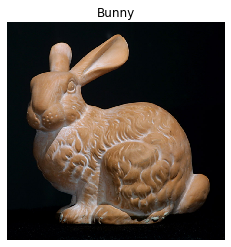

In [0]:
# Download an image
bunny = imageio.imread('https://www.cc.gatech.edu/~turk/bunny/stanford-bunny-photo.jpg')
bunny = skimage.transform.resize(bunny, (720, 720))
h, w, c = bunny.shape
print('Downloaded an image and resized it to be size %dx%dx%d' % (h, w, c))

plt.imshow(bunny); plt.grid(False); plt.axis('off'); plt.title('Bunny'); 

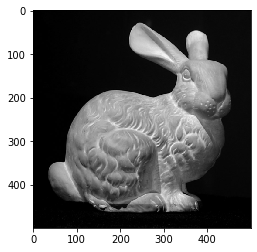

In [0]:
# Create or re-enter default session
with tf.Session() as session:

    # Define input tensor placeholder
    # Note: bunny.dtype == np.uint8 == tf.uint8
    #       bunny.shape == (720, 720, 3)
    input_image = tf.placeholder(bunny.dtype, bunny.shape, name='bunny')
                                 
    
    # Define a few operations
    scaled_image = tf.image.resize_images(input_image, size=(500, 500))
    flipped_image = tf.image.flip_left_right(scaled_image)
    grayscale_image = tf.image.rgb_to_grayscale(flipped_image)
    
    # Perform operations with concrete input provided via `feed_dict`
    output_image = session.run(
        fetches=grayscale_image,
        feed_dict={
            # Note how `input_image` is the python variable for a tf.placeholder
            input_image: bunny,
        }
    )

plt.imshow(output_image.reshape(500, 500), cmap='gray');
session.close()

With `tf.placeholder` we were able to specify a variable which would take a certain data type (unsigned 8-bit int) and shape (720 x 720 x 3).

We were then able to make this a concrete variable by providing data when called `tf.Session.run`. If the data for the placeholder is not specified, the `tf.Session.run` call will fail.

Note that:

1. When an operation is run via `tf.Session.run`, all dependent operations will be run automatically. As you can see above, the bunny was upscaled and flipped though we only evaluated the `grayscale_image` tensor.

2. When `tf.Session.run` is run again, all operations will be re-evaluated, and `tf.placeholder` instances need to have new data specified. 

3. It is possible to specify data for any Tensorflow tensor. For simplicity (and to avoid confusion), it is recommended to use `feed_dict` only for `tf.placeholder`s.

And of course, we can now feed any image of size $720\times 720$ to our placeholder. For example, a corgi:

---



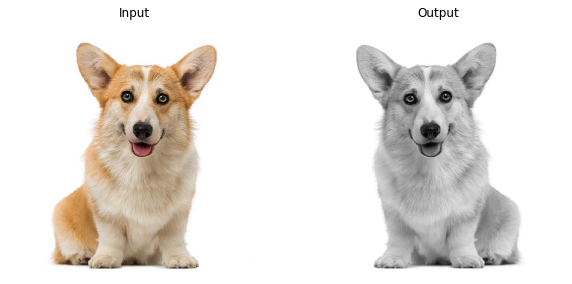

In [0]:
# Grab corgi image of size 316 x 316
corgi = imageio.imread('https://t1.ea.ltmcdn.com/en/razas/0/5/5/img_550_pembroke-welsh-corgi_0_600.jpg')
corgi = skimage.transform.resize(corgi, (720, 720))

# Perform pre-defined operations
with tf.Session() as session:
    output_image = session.run(
        fetches=grayscale_image,
        feed_dict={
            input_image: corgi,
        }
    )

# Show input and output images
fig = plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1); plt.grid(False); plt.axis('off'); plt.title('Input'); plt.imshow(corgi)
plt.subplot(1, 2, 2); plt.grid(False); plt.axis('off'); plt.title('Output'); plt.imshow(output_image.reshape(500, 500), cmap='gray')

## 4. Training

Now we can put our knowledge together to train a simple linear regression model which can predict house prices in the Boston area during the 70s. See [this page](http://scikit-learn.org/stable/datasets/index.html#boston-house-prices-dataset) for more information.

This dataset consists of:
- 13 features
- 1 label
- 506 entries

Let's get the dataset first.

In [0]:
# Set seed to make result reproducible
np.random.seed(12345)

# Grab dataset
xs, ys = sklearn.datasets.load_boston(return_X_y=True)
ys = ys.reshape(-1, 1)  # Make ys 2-dimensional (was vector)

# Record some known dimensions
num_entries, num_features = xs.shape
_, num_labels= ys.shape

# xs has num_entries rows and the following columns.
#
# CRIM    per capita crime rate by town
# ZN      proportion of residential land zoned for lots over 25,000 sq.ft.
# INDUS   proportion of non-retail business acres per town
# CHAS    Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
# NOX     nitric oxides concentration (parts per 10 million)
# RM      average number of rooms per dwelling
# AGE     proportion of owner-occupied units built prior to 1940
# DIS     weighted distances to five Boston employment centres
# RAD     index of accessibility to radial highways
# TAX     full-value property-tax rate per $10,000
# PTRATIO pupil-teacher ratio by town
# B       1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
# LSTAT   % lower status of the population

# ys consists of the following:
#
# MEDV    Median value of owner-occupied homes in $1000’s

We can now split the dataset into training data and test data.

Note that in practice, you should further create a validation set on which you tune hyperparameters.

In [0]:
# Split given data
num_test_entries = 64
num_training_entries = num_entries - num_test_entries

# We should like to shuffle the data before making splits.
# Achieve this by creating permutations of available indices.
all_indices_randomized = np.random.permutation(num_entries)

# Select training indices
training_indices = all_indices_randomized[:num_training_entries]
training_indices = sorted(training_indices)
training_data = (xs[training_indices, :], ys[training_indices, :])

# Select test indices
test_indices = all_indices_randomized[-num_test_entries:]
test_indices = sorted(test_indices)
test_data = (xs[test_indices, :], ys[test_indices, :])

print('Training data has %d entries.' % num_training_entries)
print('Test data has %d entries.' % num_test_entries)

Training data has 442 entries.
Test data has 64 entries.


---

You can use any of the following libraries for reading input data:

- [`imageio.imread`](https://imageio.readthedocs.io/en/latest/userapi.html) for images.
- [`scipy.io.loadmat`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.io.loadmat.html) for Matlab `.mat` files. Make sure to use the `squeeze_me` argument!
- [`h5py.File`](http://docs.h5py.org/en/latest/high/file.html) for HDF5.
- [`numpy.loadtxt`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.loadtxt.html) for `csv` files or other text-based data.
- Python's [`pickle`](https://docs.python.org/3/library/pickle.html) is a popular format as well, but beware of compatibility between Python versions.

and last but not least, [`pandas`](https://pandas.pydata.org/pandas-docs/stable/reference/io.html) is a good option for general data reading.

---

We can now define a very simple neural network.
In this example, we use [`tf.layers.dense`](https://www.tensorflow.org/api_docs/python/tf/layers/dense).
While it is possible to manually define weights and biases, this is no longer necessary with tensorflow and can make your code unnecessarily complex.

In [0]:
# Reset Tensorflow graph and create new session
tf.reset_default_graph()
session = tf.Session()

batch_size = 64
learning_rate = 0.0025

# Define linear regression model
input_tensor = tf.placeholder(tf.float32, (batch_size, num_features))
label_tensor = tf.placeholder(tf.float32, (batch_size, num_labels))
output_tensor = tf.layers.dense(
    inputs=input_tensor,
    units=num_labels,
    use_bias=True,
)

By defining an optimizer, we can express how the constructed computational graph should be optimized. This involves:

1. Selecting an [optimization method](https://www.tensorflow.org/api_docs/python/tf/train/Optimizer) such as stochastic gradient descent (Adam is popular).
2. Setting learning rate and other optimizer specific parameters.
3. Defining a loss or cost function.
4. Selecting variables which can be optimized.

To optimize only selected variables, one can:
1. Specify variable names via the commonly found `name` keyword argument or via [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope).
2. Retrieve all trainable variables via [`tf.trainable_variables()`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables)
3. Select the variables you need to train.
4. Specify the selected variables via the `var_list` keyword argument of [`tf.Optimizer.minimize`](https://www.tensorflow.org/api_docs/python/tf/train/Optimizer#minimize) 

In our example below, we optimize all optimizeable variables (default).

In [0]:
# Define a mean-squared-error loss function
loss_tensor = tf.reduce_mean(tf.squared_difference(output_tensor, label_tensor))

# Define optimizer
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
optimize_op = optimizer.minimize(loss_tensor)

The model and its associated tensors and operations are now defined.

Some tensors, such as optimizable variables (weights and biases) must be explicitly initialized.

In practice, the following is always called after the model is built but before training begins.

In [0]:
# All tensors and operations need to be initialized before usage.
session.run(tf.global_variables_initializer())

With the model defined and initialized, we can train it by evaluating the `optimize_op` operation.

In [0]:
# Set seed to make result reproducible
np.random.seed(12345)

# Decide how many steps to train for
num_training_steps = 5001
for i in range(num_training_steps):

    # Draw samples from training data to form a batch
    indices = np.random.choice(num_training_entries, size=batch_size, replace=False)
    indices = sorted(indices)

    # Run update step and simultaneously calculate training loss
    training_loss, _ = session.run(
        [loss_tensor, optimize_op], 
        feed_dict={
            input_tensor: training_data[0][indices, :],
            label_tensor: training_data[1][indices, :],
        }
    )
    
    if i % 500 == 0:
        print('Step %04d> training loss: %.2f' % (i, training_loss))

Step 0000> training loss: 15927.85
Step 0500> training loss: 55.60
Step 1000> training loss: 69.99
Step 1500> training loss: 59.71
Step 2000> training loss: 32.24
Step 2500> training loss: 52.05
Step 3000> training loss: 49.89
Step 3500> training loss: 37.02
Step 4000> training loss: 48.20
Step 4500> training loss: 19.04
Step 5000> training loss: 43.35


Now that we have trained a model, let's test its performance.

In [0]:
test_loss = session.run(
    loss_tensor,
    feed_dict={
        input_tensor: test_data[0],
        label_tensor: test_data[1],
    }
)
print('Mean test loss = %.2f' % test_loss)

Mean test loss = 55.38


Now let's quickly make a plot of *house value* vs *number of rooms*...

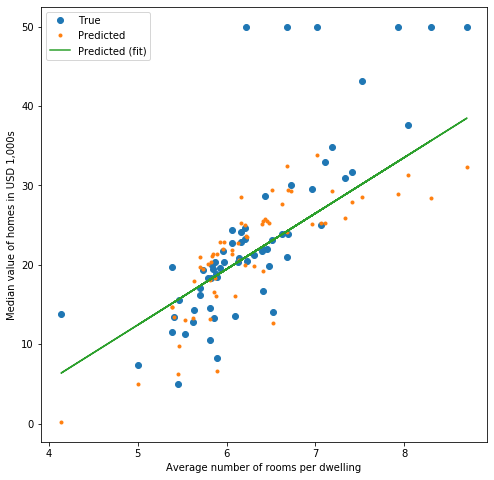

In [0]:
# Gather data to plot
x = test_data[0][:, 5]  # average number of rooms per dwelling
y_true = test_data[1]

# Note that we don't feed labels as output_tensor doesn't require them.
y_predicted = session.run(
    output_tensor,
    feed_dict={
        input_tensor: test_data[0],
        # label_tensor: test_data[1],  
    }
).flatten()

# Plot ground-truth and predictions
plt.figure(figsize=(8, 8))
plt.plot(x, y_true, 'o', label='True')
plt.plot(x, y_predicted, '.', label='Predicted')

# Plot linear-fit for y_predicted
slope, intercept, _, _, _ = scipy.stats.linregress(x, y_predicted)
plt.plot(x, slope * np.array(x) + intercept, label='Predicted (fit)')

# Graph formatting
plt.xlabel('Average number of rooms per dwelling')
plt.ylabel('Median value of homes in USD 1,000s')
plt.legend()

I suppose we could say that houses in the Boston area in the 70s tended to cost more when built to have more rooms.

## 5. Tensorboard and Monitoring Progress

Last but not least, we will briefly touch on the usage of [**Tensorboard**](https://github.com/tensorflow/tensorboard).

Tensorboard allows you to easily monitor your model's progress by providing an intuitive interface displaying metrics over time. In addition, it allows you to:
1. View image outputs
2. View histogram/distribution plots of model parameters
3. Visualize model architecture

and others...

Follow these simple steps to make your experience with tensorboard easier.

---

### Scoping of variables and summary operations

Now, we run the same training loop with tensorboard routines. You should visit the URL printed after creating TensorBoardColab object in the beginning.

In [0]:
# Reset Tensorflow graph and create new session
tf.reset_default_graph()
session = tf.Session()

batch_size = 64
learning_rate = 0.0025

# Define linear regression model
input_tensor = tf.placeholder(tf.float32, (batch_size, num_features))
label_tensor = tf.placeholder(tf.float32, (batch_size, num_labels))
output_tensor = tf.layers.dense(
    inputs=input_tensor,
    units=num_labels,
    use_bias=True,
    name="dense_layer",
)

# Define a mean-squared-error loss function
loss_tensor = tf.reduce_mean(tf.squared_difference(output_tensor, label_tensor))

# Define optimizer
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
optimize_op = optimizer.minimize(loss_tensor)

# All tensors and operations need to be initialized before usage.
session.run(tf.global_variables_initializer())

# Set seed to make result reproducible
np.random.seed(12345)

# Decide how many steps to train for
num_training_steps = 5001

train_writer = tbc.get_deep_writers("single_layer_model")
train_writer.add_graph(session.graph)
training_loss_summary = tf.summary.scalar('training_loss', loss_tensor)

# Get weight and bias tensors. Note that they are updated during training.
# We will visualize the distribution of weight and bias values.
weight = tf.trainable_variables()[0]
bias = tf.trainable_variables()[1]
weight_histogram_summary = tf.summary.histogram('weights', weight)
bias_histogram_summary = tf.summary.histogram('bias', bias)
summary_op = tf.summary.merge_all()

for i in range(num_training_steps):

    # Draw samples from training data to form a batch
    indices = np.random.choice(num_training_entries, size=batch_size, replace=False)
    indices = sorted(indices)

    # Run update step and simultaneously calculate training loss
    training_loss, summary, _ = session.run(
        [loss_tensor, summary_op, optimize_op], 
        feed_dict={
            input_tensor: training_data[0][indices, :],
            label_tensor: training_data[1][indices, :],
        }
    )
    train_writer.add_summary(summary, i)
    
    if i % 500 == 0:
        print('Step %04d> training loss: %.2f' % (i, training_loss))


Step 0000> training loss: 121170.09
Step 0500> training loss: 364.26
Step 1000> training loss: 175.89
Step 1500> training loss: 125.32
Step 2000> training loss: 76.76
Step 2500> training loss: 58.74
Step 3000> training loss: 72.14
Step 3500> training loss: 63.05
Step 4000> training loss: 56.31
Step 4500> training loss: 33.52
Step 5000> training loss: 63.50


You will see training loss, distribution of weight & bias parameter values and our graph.

### Write to File

The given example works for Tensorboard operating in Colaboratory environment. Similarly, you can save your model and summary in
your local file system and visualize by using tensorboard. This is how you monitor your project experiments.

Let's write the output using [`tf.summary.FileWriter`](https://www.tensorflow.org/api_docs/python/tf/summary/FileWriter).

In [0]:
logdir = './logs'

# This is just auxiliary code to remove the output directory to prevent duplicate logs
if os.path.isdir(logdir):
    import shutil
    shutil.rmtree(logdir)

# Create writer instance and write summary
writer = tf.summary.FileWriter(logdir=logdir, graph=session.graph)
writer.add_summary(summary, global_step=0)
writer.flush()  # Only calling now (as demo) to ensure content is written to disk.

On a standard machine setup, we can now view our stored logs using Tensorboard for example by calling:

    tensorboard --port 8008 --logdir ./logs

You can learn more about Tensorboard [over here](https://www.tensorflow.org/programmers_guide/summaries_and_tensorboard).

Note that there are other types of summaries, such as [`image`](https://www.tensorflow.org/api_docs/python/tf/summary/image) and [`histogram`](https://www.tensorflow.org/api_docs/python/tf/summary/histogram) (which are particularly useful for analyzing learned weights and biases.
When handling multiple summary operations, you can merge them into one using [`tf.summary.merge`](https://www.tensorflow.org/api_docs/python/tf/summary/merge).

In general, you will not see data or metrics which you do not explicitly request to be logged. You must therefore:

1. Set the correct variable scope.
2. Define summary operations as required for tensors (which yields a `tf.Summary` protocol buffer when run)
3. Evaluate the summary operations (every $k$ steps during training or testing)
4. and finally, write the outputs to a `tf.summary.FileWriter`.

---

# End

This tutorial now ends. If you have any further questions about how tensorflow works, please do the following:

1. Search the web (ie. search [StackOverflow](https://stackoverflow.com/questions/tagged/tensorflow)) for solutions to your question.
2. Check our project skeleton code (to be released) to see if there is similar code to what you are attempting.
3. If the question remains unanswered, ask us (and your peers) via [the course Piazza](https://piazza.com/class/k6jbn40blq36yx).
4. If you still have difficulty getting help or feedback, you may contact TAs directly.

---

## Questions and Additional Exercises
Tensorflow library has plug&play like API, enabling designing sophisticated models. You can copy the cell with tensorboard example and modify the model. You can compare different models in Tensorboard by passing unique names to 
```
train_writer = tbc.get_deep_writers("single_layer_model")
```

<ol>
    <li><b>Increasing Model Capacity</b></li>
    In this toy example we only used one layer. You can try reducing the loss further by stacking more dense layers. Please note that your model can easily overfit and give worse performance. 
  
  <li><b>Learning Rate</b></li>
  You may experiment with very large and very small learning rates. 
  
  <li><b>New Dataset</b></li>
 In the first exercise, you were given an eye gaze dataset and expected to implement a simple neural network by using Numpy library. Now, you can try solving the same task with Tensorflow. The angular error was implemented in Numpy. Hence, you can't directly use this error as your objective for a Tensorflow model. 


<ol>
   <li>You can use a standart objective such as the mean squared error. In the training loop, after you get the model prediction by running session.run you can evaluate the angle loss.
 </li>
  <li> If you strive for training the model by using the angle loss, you need to implement it by using Tensorflow functions. Another option could be using <a href="https://www.tensorflow.org/api_docs/python/tf/py_func">tf.py_func</a> wrapper, allows evaluation of Python functions in Tensorflow graph. Note that this is given as a side note and it is not covered in this tutorial. 
 </li>
</ol>


</ol>